In [1]:
# Uncomment and run the commands below if imports fail
!pip install jovian --upgrade --quiet
!conda install numpy pandas pytorch torchvision cpuonly -c pytorch -y
!pip install matplotlib --upgrade --quiet

Solving environment: ...working... done

# All requested packages already installed.



In [2]:
import jovian
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import FashionMNIST
from torchvision.transforms import transforms
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
%matplotlib inline

In [3]:
# Project name used for jovian.commit
project_name = 'fashion-mnist-feedforward'

# Hyperparmeters
batch_size = 64
learning_rate = 0.0001

# Other constants
input_size = 28*28
num_classes = 10

# Labels
labels_map = {0 : 'T-Shirt', 1 : 'Trouser', 2 : 'Pullover', 3 : 'Dress', 4 : 'Coat', 5 : 'Sandal', 6 : 'Shirt',
              7 : 'Sneaker', 8 : 'Bag', 9 : 'Ankle Boot'}

In [4]:
# Download dataset
dataset = FashionMNIST(root='data/', train=True, transform=transforms.ToTensor(), download=True)

# Training validation & test dataset
train_ds, val_ds = random_split(dataset, [50000, 10000])
test_ds = FashionMNIST(root='data/', train=False, transform=transforms.ToTensor())

# Dataloaders
train_loader = DataLoader(train_ds, batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size*2)
test_loader = DataLoader(test_ds, batch_size*2)

Label: Coat (4)


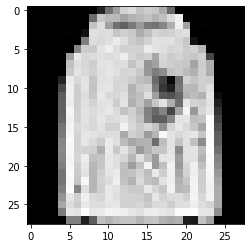

In [5]:
image, label = train_ds[0]
plt.imshow(image[0], cmap='gray')
print('Label:', labels_map[label], f'({label})')

images.shape: torch.Size([64, 1, 28, 28])


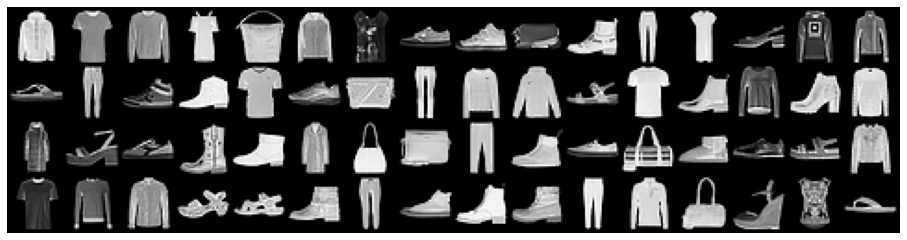

In [6]:
for images, _ in train_loader:
    print('images.shape:', images.shape)
    plt.figure(figsize=(16,8))
    plt.axis('off')
    plt.imshow(make_grid(images, nrow=16).permute((1, 2, 0)))
    break

In [7]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [8]:
class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))

In [9]:
def evaluate(model, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [10]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

In [11]:
device = get_default_device()
device

device(type='cpu')

In [12]:
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [13]:
def plot_losses(history):
    losses = [x['val_loss'] for x in history]
    plt.plot(losses, '-x')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.title('Loss vs. No. of epochs');

In [14]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

In [15]:
train_loader = DeviceDataLoader(train_loader, device)
val_loader = DeviceDataLoader(val_loader, device)
test_loader = DeviceDataLoader(test_loader, device)

In [16]:
input_size = 28*28
output_size = 10

In [17]:
class FashionMNISTModel(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.linear1 = nn.Linear(input_size, 392)
        self.linear2 = nn.Linear(392, 196)
        self.linear3 = nn.Linear(196, 98)
        self.linear4 = nn.Linear(98, output_size)
        
    def forward(self, xb):
        # Flatten images into vectors
        out = xb.view(xb.size(0), -1)
        
        # Apply layers & activation functions
        out = self.linear1(out)
        out = F.relu(out)
        
        out = self.linear2(out)
        out = F.relu(out)
        
        out = self.linear3(out)
        out = F.relu(out)
        
        out = self.linear4(out)
        
        return out

In [18]:
model = to_device(FashionMNISTModel(), device)

In [19]:
history = [evaluate(model, val_loader)]
history

[{'val_loss': 2.3045408725738525, 'val_acc': 0.09948576241731644}]

In [20]:
epochs_list = [50, 25, 10, 5]
learning_rates = [0.1, 0.001, 0.0001, 0.00001]

In [21]:
history += fit(epochs_list[0], learning_rates[0], model, train_loader, val_loader)

Epoch [0], val_loss: 0.5464, val_acc: 0.8022
Epoch [1], val_loss: 0.5957, val_acc: 0.7912
Epoch [2], val_loss: 0.5374, val_acc: 0.8170
Epoch [3], val_loss: 0.4160, val_acc: 0.8452
Epoch [4], val_loss: 0.3592, val_acc: 0.8616
Epoch [5], val_loss: 0.3411, val_acc: 0.8746
Epoch [6], val_loss: 0.4097, val_acc: 0.8546
Epoch [7], val_loss: 0.3119, val_acc: 0.8856
Epoch [8], val_loss: 1.0484, val_acc: 0.7325
Epoch [9], val_loss: 0.3409, val_acc: 0.8721
Epoch [10], val_loss: 0.3297, val_acc: 0.8802
Epoch [11], val_loss: 0.3662, val_acc: 0.8645
Epoch [12], val_loss: 0.4984, val_acc: 0.8298
Epoch [13], val_loss: 0.3204, val_acc: 0.8833
Epoch [14], val_loss: 0.3363, val_acc: 0.8748
Epoch [15], val_loss: 0.3837, val_acc: 0.8728
Epoch [16], val_loss: 0.5284, val_acc: 0.8244
Epoch [17], val_loss: 0.3188, val_acc: 0.8861
Epoch [18], val_loss: 0.3489, val_acc: 0.8803
Epoch [19], val_loss: 0.3595, val_acc: 0.8736
Epoch [20], val_loss: 0.2908, val_acc: 0.8942
Epoch [21], val_loss: 0.3635, val_acc: 0.877

In [22]:
history += fit(epochs_list[1], learning_rates[1], model, train_loader, val_loader)

Epoch [0], val_loss: 0.3684, val_acc: 0.9082
Epoch [1], val_loss: 0.3700, val_acc: 0.9080
Epoch [2], val_loss: 0.3724, val_acc: 0.9080
Epoch [3], val_loss: 0.3742, val_acc: 0.9086
Epoch [4], val_loss: 0.3760, val_acc: 0.9093
Epoch [5], val_loss: 0.3774, val_acc: 0.9097
Epoch [6], val_loss: 0.3784, val_acc: 0.9094
Epoch [7], val_loss: 0.3798, val_acc: 0.9086
Epoch [8], val_loss: 0.3809, val_acc: 0.9091
Epoch [9], val_loss: 0.3825, val_acc: 0.9096
Epoch [10], val_loss: 0.3832, val_acc: 0.9089
Epoch [11], val_loss: 0.3836, val_acc: 0.9091
Epoch [12], val_loss: 0.3846, val_acc: 0.9092
Epoch [13], val_loss: 0.3860, val_acc: 0.9093
Epoch [14], val_loss: 0.3871, val_acc: 0.9088
Epoch [15], val_loss: 0.3878, val_acc: 0.9087
Epoch [16], val_loss: 0.3882, val_acc: 0.9087
Epoch [17], val_loss: 0.3886, val_acc: 0.9093
Epoch [18], val_loss: 0.3896, val_acc: 0.9092
Epoch [19], val_loss: 0.3905, val_acc: 0.9091
Epoch [20], val_loss: 0.3910, val_acc: 0.9094
Epoch [21], val_loss: 0.3919, val_acc: 0.909

In [23]:
history += fit(epochs_list[2], learning_rates[2], model, train_loader, val_loader)

Epoch [0], val_loss: 0.3934, val_acc: 0.9092
Epoch [1], val_loss: 0.3935, val_acc: 0.9091
Epoch [2], val_loss: 0.3936, val_acc: 0.9091
Epoch [3], val_loss: 0.3937, val_acc: 0.9092
Epoch [4], val_loss: 0.3937, val_acc: 0.9092
Epoch [5], val_loss: 0.3938, val_acc: 0.9092
Epoch [6], val_loss: 0.3938, val_acc: 0.9092
Epoch [7], val_loss: 0.3939, val_acc: 0.9091
Epoch [8], val_loss: 0.3940, val_acc: 0.9091
Epoch [9], val_loss: 0.3940, val_acc: 0.9091


In [24]:
history += fit(epochs_list[3], learning_rates[3], model, train_loader, val_loader)

Epoch [0], val_loss: 0.3940, val_acc: 0.9091
Epoch [1], val_loss: 0.3940, val_acc: 0.9091
Epoch [2], val_loss: 0.3940, val_acc: 0.9091
Epoch [3], val_loss: 0.3940, val_acc: 0.9091
Epoch [4], val_loss: 0.3940, val_acc: 0.9091


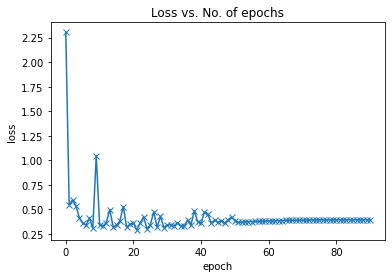

In [25]:
plot_losses(history)

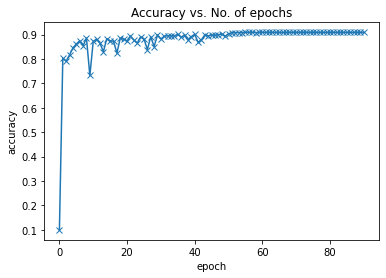

In [26]:
plot_accuracies(history)

In [27]:
final_test_eval = evaluate(model, test_loader)
final_test_eval

{'val_loss': 0.4475352168083191, 'val_acc': 0.9038766026496887}

In [28]:
def predict_image(img, model):
    xb = img.unsqueeze(0)
    yb = model(xb)
    _, preds  = torch.max(yb, dim=1)
    return preds[0].item()

Label: Sneaker (7)
Predicted: Sneaker (7)


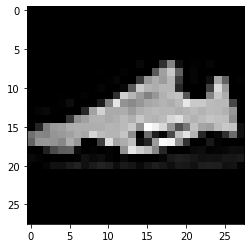

In [37]:
img, label = test_ds[999]
plt.imshow(img[0], cmap='gray')
print('Label:', labels_map[label], f'({label})')
print('Predicted:', labels_map[label], f'({predict_image(img, model)})')

In [38]:
incorrect_count = 0

for data in test_ds:
    img, label = data
    print('Label:', label, ', Predicted:', predict_image(img, model))
    if (label != predict_image(img, model)):
        incorrect_count += 1

Label: 9 , Predicted: 9
Label: 2 , Predicted: 2
Label: 1 , Predicted: 1
Label: 1 , Predicted: 1
Label: 6 , Predicted: 6
Label: 1 , Predicted: 1
Label: 4 , Predicted: 4
Label: 6 , Predicted: 6
Label: 5 , Predicted: 5
Label: 7 , Predicted: 7
Label: 4 , Predicted: 4
Label: 5 , Predicted: 5
Label: 7 , Predicted: 5
Label: 3 , Predicted: 3
Label: 4 , Predicted: 4
Label: 1 , Predicted: 1
Label: 2 , Predicted: 2
Label: 4 , Predicted: 2
Label: 8 , Predicted: 8
Label: 0 , Predicted: 0
Label: 2 , Predicted: 2
Label: 5 , Predicted: 5
Label: 7 , Predicted: 7
Label: 9 , Predicted: 5
Label: 1 , Predicted: 1
Label: 4 , Predicted: 4
Label: 6 , Predicted: 6
Label: 0 , Predicted: 0
Label: 9 , Predicted: 9
Label: 3 , Predicted: 6
Label: 8 , Predicted: 8
Label: 8 , Predicted: 8
Label: 3 , Predicted: 3
Label: 3 , Predicted: 3
Label: 8 , Predicted: 8
Label: 0 , Predicted: 0
Label: 7 , Predicted: 7
Label: 5 , Predicted: 5
Label: 7 , Predicted: 7
Label: 9 , Predicted: 9
Label: 6 , Predicted: 0
Label: 1 , Predi

Label: 2 , Predicted: 6
Label: 9 , Predicted: 9
Label: 4 , Predicted: 4
Label: 2 , Predicted: 2
Label: 1 , Predicted: 1
Label: 5 , Predicted: 5
Label: 4 , Predicted: 4
Label: 5 , Predicted: 5
Label: 3 , Predicted: 3
Label: 8 , Predicted: 8
Label: 5 , Predicted: 5
Label: 8 , Predicted: 8
Label: 4 , Predicted: 4
Label: 4 , Predicted: 4
Label: 8 , Predicted: 8
Label: 9 , Predicted: 9
Label: 8 , Predicted: 8
Label: 6 , Predicted: 6
Label: 2 , Predicted: 2
Label: 4 , Predicted: 4
Label: 4 , Predicted: 4
Label: 2 , Predicted: 2
Label: 4 , Predicted: 4
Label: 1 , Predicted: 1
Label: 6 , Predicted: 6
Label: 1 , Predicted: 1
Label: 3 , Predicted: 3
Label: 0 , Predicted: 0
Label: 9 , Predicted: 7
Label: 8 , Predicted: 8
Label: 8 , Predicted: 8
Label: 6 , Predicted: 6
Label: 5 , Predicted: 5
Label: 3 , Predicted: 3
Label: 1 , Predicted: 1
Label: 9 , Predicted: 9
Label: 5 , Predicted: 5
Label: 3 , Predicted: 3
Label: 3 , Predicted: 3
Label: 0 , Predicted: 0
Label: 1 , Predicted: 1
Label: 0 , Predi

Label: 9 , Predicted: 9
Label: 3 , Predicted: 3
Label: 5 , Predicted: 5
Label: 8 , Predicted: 8
Label: 5 , Predicted: 5
Label: 4 , Predicted: 4
Label: 7 , Predicted: 7
Label: 2 , Predicted: 2
Label: 8 , Predicted: 8
Label: 5 , Predicted: 5
Label: 9 , Predicted: 9
Label: 3 , Predicted: 3
Label: 3 , Predicted: 3
Label: 6 , Predicted: 6
Label: 7 , Predicted: 7
Label: 1 , Predicted: 1
Label: 7 , Predicted: 7
Label: 3 , Predicted: 3
Label: 5 , Predicted: 5
Label: 4 , Predicted: 4
Label: 4 , Predicted: 6
Label: 5 , Predicted: 5
Label: 8 , Predicted: 8
Label: 3 , Predicted: 3
Label: 7 , Predicted: 7
Label: 1 , Predicted: 1
Label: 2 , Predicted: 2
Label: 6 , Predicted: 6
Label: 1 , Predicted: 1
Label: 9 , Predicted: 9
Label: 8 , Predicted: 8
Label: 2 , Predicted: 2
Label: 7 , Predicted: 7
Label: 1 , Predicted: 1
Label: 3 , Predicted: 3
Label: 7 , Predicted: 7
Label: 5 , Predicted: 5
Label: 9 , Predicted: 9
Label: 9 , Predicted: 9
Label: 1 , Predicted: 1
Label: 8 , Predicted: 8
Label: 2 , Predi

Label: 2 , Predicted: 2
Label: 9 , Predicted: 9
Label: 0 , Predicted: 6
Label: 3 , Predicted: 3
Label: 4 , Predicted: 4
Label: 4 , Predicted: 4
Label: 6 , Predicted: 6
Label: 6 , Predicted: 6
Label: 5 , Predicted: 5
Label: 2 , Predicted: 2
Label: 2 , Predicted: 2
Label: 5 , Predicted: 5
Label: 6 , Predicted: 6
Label: 1 , Predicted: 1
Label: 4 , Predicted: 4
Label: 2 , Predicted: 2
Label: 5 , Predicted: 5
Label: 4 , Predicted: 4
Label: 4 , Predicted: 4
Label: 8 , Predicted: 8
Label: 0 , Predicted: 0
Label: 2 , Predicted: 2
Label: 4 , Predicted: 4
Label: 0 , Predicted: 0
Label: 6 , Predicted: 6
Label: 2 , Predicted: 6
Label: 6 , Predicted: 6
Label: 8 , Predicted: 8
Label: 3 , Predicted: 3
Label: 8 , Predicted: 8
Label: 2 , Predicted: 2
Label: 0 , Predicted: 0
Label: 4 , Predicted: 4
Label: 4 , Predicted: 4
Label: 8 , Predicted: 8
Label: 8 , Predicted: 8
Label: 4 , Predicted: 4
Label: 5 , Predicted: 5
Label: 2 , Predicted: 2
Label: 2 , Predicted: 2
Label: 3 , Predicted: 3
Label: 0 , Predi

Label: 3 , Predicted: 3
Label: 2 , Predicted: 6
Label: 0 , Predicted: 0
Label: 2 , Predicted: 2
Label: 7 , Predicted: 7
Label: 3 , Predicted: 3
Label: 6 , Predicted: 6
Label: 8 , Predicted: 8
Label: 3 , Predicted: 3
Label: 9 , Predicted: 7
Label: 7 , Predicted: 7
Label: 3 , Predicted: 3
Label: 1 , Predicted: 1
Label: 7 , Predicted: 7
Label: 5 , Predicted: 5
Label: 8 , Predicted: 8
Label: 8 , Predicted: 8
Label: 2 , Predicted: 2
Label: 0 , Predicted: 0
Label: 6 , Predicted: 2
Label: 6 , Predicted: 4
Label: 4 , Predicted: 4
Label: 6 , Predicted: 5
Label: 5 , Predicted: 5
Label: 7 , Predicted: 7
Label: 0 , Predicted: 0
Label: 6 , Predicted: 6
Label: 6 , Predicted: 0
Label: 7 , Predicted: 7
Label: 7 , Predicted: 7
Label: 3 , Predicted: 3
Label: 9 , Predicted: 9
Label: 2 , Predicted: 2
Label: 5 , Predicted: 5
Label: 9 , Predicted: 9
Label: 7 , Predicted: 7
Label: 1 , Predicted: 3
Label: 7 , Predicted: 7
Label: 2 , Predicted: 4
Label: 4 , Predicted: 4
Label: 5 , Predicted: 5
Label: 1 , Predi

Label: 0 , Predicted: 0
Label: 8 , Predicted: 8
Label: 3 , Predicted: 3
Label: 8 , Predicted: 8
Label: 6 , Predicted: 6
Label: 8 , Predicted: 4
Label: 6 , Predicted: 6
Label: 0 , Predicted: 0
Label: 8 , Predicted: 8
Label: 8 , Predicted: 8
Label: 8 , Predicted: 3
Label: 2 , Predicted: 2
Label: 9 , Predicted: 9
Label: 3 , Predicted: 3
Label: 2 , Predicted: 2
Label: 0 , Predicted: 0
Label: 8 , Predicted: 8
Label: 5 , Predicted: 5
Label: 7 , Predicted: 7
Label: 0 , Predicted: 0
Label: 1 , Predicted: 1
Label: 1 , Predicted: 1
Label: 1 , Predicted: 1
Label: 9 , Predicted: 9
Label: 5 , Predicted: 5
Label: 1 , Predicted: 1
Label: 3 , Predicted: 3
Label: 3 , Predicted: 3
Label: 6 , Predicted: 6
Label: 0 , Predicted: 0
Label: 8 , Predicted: 8
Label: 2 , Predicted: 4
Label: 1 , Predicted: 1
Label: 3 , Predicted: 3
Label: 8 , Predicted: 8
Label: 8 , Predicted: 8
Label: 6 , Predicted: 0
Label: 7 , Predicted: 7
Label: 5 , Predicted: 5
Label: 6 , Predicted: 6
Label: 6 , Predicted: 6
Label: 7 , Predi

Label: 0 , Predicted: 0
Label: 3 , Predicted: 3
Label: 0 , Predicted: 0
Label: 0 , Predicted: 0
Label: 0 , Predicted: 0
Label: 5 , Predicted: 5
Label: 7 , Predicted: 7
Label: 5 , Predicted: 5
Label: 0 , Predicted: 0
Label: 7 , Predicted: 7
Label: 9 , Predicted: 9
Label: 1 , Predicted: 1
Label: 6 , Predicted: 2
Label: 4 , Predicted: 4
Label: 8 , Predicted: 8
Label: 9 , Predicted: 9
Label: 3 , Predicted: 3
Label: 5 , Predicted: 5
Label: 6 , Predicted: 2
Label: 0 , Predicted: 0
Label: 4 , Predicted: 4
Label: 4 , Predicted: 4
Label: 7 , Predicted: 7
Label: 8 , Predicted: 8
Label: 9 , Predicted: 9
Label: 1 , Predicted: 1
Label: 8 , Predicted: 8
Label: 2 , Predicted: 2
Label: 5 , Predicted: 5
Label: 5 , Predicted: 5
Label: 3 , Predicted: 3
Label: 1 , Predicted: 1
Label: 1 , Predicted: 1
Label: 8 , Predicted: 8
Label: 8 , Predicted: 8
Label: 3 , Predicted: 3
Label: 0 , Predicted: 0
Label: 7 , Predicted: 7
Label: 0 , Predicted: 0
Label: 1 , Predicted: 1
Label: 8 , Predicted: 8
Label: 1 , Predi

Label: 5 , Predicted: 5
Label: 1 , Predicted: 1
Label: 9 , Predicted: 9
Label: 4 , Predicted: 2
Label: 4 , Predicted: 4
Label: 2 , Predicted: 2
Label: 4 , Predicted: 3
Label: 8 , Predicted: 8
Label: 6 , Predicted: 6
Label: 7 , Predicted: 7
Label: 1 , Predicted: 1
Label: 3 , Predicted: 3
Label: 0 , Predicted: 0
Label: 7 , Predicted: 7
Label: 3 , Predicted: 3
Label: 5 , Predicted: 5
Label: 8 , Predicted: 8
Label: 1 , Predicted: 1
Label: 4 , Predicted: 4
Label: 2 , Predicted: 2
Label: 3 , Predicted: 3
Label: 4 , Predicted: 4
Label: 8 , Predicted: 8
Label: 8 , Predicted: 8
Label: 8 , Predicted: 8
Label: 4 , Predicted: 4
Label: 8 , Predicted: 8
Label: 1 , Predicted: 1
Label: 8 , Predicted: 8
Label: 9 , Predicted: 9
Label: 3 , Predicted: 3
Label: 0 , Predicted: 0
Label: 6 , Predicted: 6
Label: 0 , Predicted: 0
Label: 2 , Predicted: 2
Label: 9 , Predicted: 9
Label: 7 , Predicted: 7
Label: 3 , Predicted: 3
Label: 7 , Predicted: 7
Label: 0 , Predicted: 0
Label: 1 , Predicted: 1
Label: 3 , Predi

Label: 3 , Predicted: 3
Label: 4 , Predicted: 4
Label: 1 , Predicted: 1
Label: 5 , Predicted: 5
Label: 6 , Predicted: 4
Label: 7 , Predicted: 7
Label: 5 , Predicted: 5
Label: 0 , Predicted: 0
Label: 7 , Predicted: 7
Label: 6 , Predicted: 6
Label: 2 , Predicted: 2
Label: 0 , Predicted: 3
Label: 5 , Predicted: 5
Label: 1 , Predicted: 1
Label: 1 , Predicted: 1
Label: 3 , Predicted: 0
Label: 7 , Predicted: 7
Label: 3 , Predicted: 3
Label: 8 , Predicted: 8
Label: 8 , Predicted: 8
Label: 7 , Predicted: 7
Label: 5 , Predicted: 5
Label: 9 , Predicted: 9
Label: 9 , Predicted: 9
Label: 5 , Predicted: 5
Label: 5 , Predicted: 5
Label: 4 , Predicted: 3
Label: 0 , Predicted: 0
Label: 7 , Predicted: 7
Label: 1 , Predicted: 1
Label: 4 , Predicted: 4
Label: 6 , Predicted: 6
Label: 0 , Predicted: 0
Label: 9 , Predicted: 9
Label: 9 , Predicted: 9
Label: 4 , Predicted: 2
Label: 6 , Predicted: 0
Label: 8 , Predicted: 8
Label: 6 , Predicted: 0
Label: 5 , Predicted: 5
Label: 7 , Predicted: 7
Label: 8 , Predi

Label: 4 , Predicted: 4
Label: 7 , Predicted: 7
Label: 6 , Predicted: 0
Label: 4 , Predicted: 4
Label: 1 , Predicted: 1
Label: 0 , Predicted: 0
Label: 0 , Predicted: 0
Label: 7 , Predicted: 7
Label: 7 , Predicted: 7
Label: 0 , Predicted: 0
Label: 7 , Predicted: 7
Label: 8 , Predicted: 8
Label: 0 , Predicted: 0
Label: 5 , Predicted: 5
Label: 6 , Predicted: 6
Label: 4 , Predicted: 4
Label: 4 , Predicted: 4
Label: 8 , Predicted: 8
Label: 9 , Predicted: 9
Label: 7 , Predicted: 7
Label: 4 , Predicted: 4
Label: 9 , Predicted: 9
Label: 5 , Predicted: 5
Label: 3 , Predicted: 3
Label: 7 , Predicted: 7
Label: 2 , Predicted: 2
Label: 4 , Predicted: 4
Label: 1 , Predicted: 1
Label: 9 , Predicted: 9
Label: 7 , Predicted: 7
Label: 8 , Predicted: 8
Label: 1 , Predicted: 1
Label: 3 , Predicted: 3
Label: 9 , Predicted: 9
Label: 3 , Predicted: 3
Label: 6 , Predicted: 4
Label: 7 , Predicted: 7
Label: 8 , Predicted: 8
Label: 6 , Predicted: 6
Label: 5 , Predicted: 5
Label: 6 , Predicted: 6
Label: 7 , Predi

Label: 3 , Predicted: 3
Label: 6 , Predicted: 6
Label: 7 , Predicted: 7
Label: 2 , Predicted: 4
Label: 4 , Predicted: 4
Label: 1 , Predicted: 1
Label: 5 , Predicted: 7
Label: 2 , Predicted: 3
Label: 0 , Predicted: 0
Label: 7 , Predicted: 7
Label: 9 , Predicted: 9
Label: 9 , Predicted: 9
Label: 1 , Predicted: 1
Label: 5 , Predicted: 5
Label: 5 , Predicted: 5
Label: 9 , Predicted: 9
Label: 1 , Predicted: 1
Label: 4 , Predicted: 4
Label: 6 , Predicted: 6
Label: 1 , Predicted: 1
Label: 2 , Predicted: 2
Label: 8 , Predicted: 8
Label: 3 , Predicted: 3
Label: 5 , Predicted: 5
Label: 7 , Predicted: 5
Label: 8 , Predicted: 8
Label: 0 , Predicted: 0
Label: 4 , Predicted: 6
Label: 2 , Predicted: 2
Label: 7 , Predicted: 7
Label: 2 , Predicted: 2
Label: 7 , Predicted: 7
Label: 5 , Predicted: 5
Label: 0 , Predicted: 0
Label: 8 , Predicted: 8
Label: 7 , Predicted: 7
Label: 8 , Predicted: 8
Label: 8 , Predicted: 2
Label: 4 , Predicted: 4
Label: 9 , Predicted: 9
Label: 2 , Predicted: 6
Label: 5 , Predi

Label: 6 , Predicted: 6
Label: 0 , Predicted: 0
Label: 5 , Predicted: 5
Label: 8 , Predicted: 8
Label: 1 , Predicted: 1
Label: 9 , Predicted: 9
Label: 3 , Predicted: 3
Label: 0 , Predicted: 6
Label: 8 , Predicted: 8
Label: 3 , Predicted: 3
Label: 8 , Predicted: 8
Label: 4 , Predicted: 4
Label: 2 , Predicted: 2
Label: 5 , Predicted: 5
Label: 6 , Predicted: 6
Label: 9 , Predicted: 9
Label: 0 , Predicted: 6
Label: 1 , Predicted: 1
Label: 4 , Predicted: 2
Label: 0 , Predicted: 0
Label: 7 , Predicted: 7
Label: 9 , Predicted: 9
Label: 0 , Predicted: 0
Label: 1 , Predicted: 1
Label: 3 , Predicted: 3
Label: 9 , Predicted: 9
Label: 5 , Predicted: 5
Label: 1 , Predicted: 1
Label: 4 , Predicted: 4
Label: 1 , Predicted: 1
Label: 1 , Predicted: 1
Label: 4 , Predicted: 3
Label: 8 , Predicted: 8
Label: 3 , Predicted: 3
Label: 9 , Predicted: 9
Label: 5 , Predicted: 5
Label: 4 , Predicted: 4
Label: 4 , Predicted: 4
Label: 3 , Predicted: 3
Label: 7 , Predicted: 7
Label: 7 , Predicted: 7
Label: 7 , Predi

Label: 1 , Predicted: 1
Label: 9 , Predicted: 9
Label: 7 , Predicted: 7
Label: 4 , Predicted: 4
Label: 5 , Predicted: 5
Label: 6 , Predicted: 0
Label: 3 , Predicted: 3
Label: 2 , Predicted: 2
Label: 4 , Predicted: 2
Label: 5 , Predicted: 5
Label: 6 , Predicted: 6
Label: 6 , Predicted: 6
Label: 5 , Predicted: 5
Label: 8 , Predicted: 8
Label: 6 , Predicted: 6
Label: 2 , Predicted: 4
Label: 2 , Predicted: 4
Label: 9 , Predicted: 9
Label: 4 , Predicted: 4
Label: 9 , Predicted: 7
Label: 8 , Predicted: 8
Label: 3 , Predicted: 3
Label: 0 , Predicted: 0
Label: 2 , Predicted: 2
Label: 7 , Predicted: 7
Label: 7 , Predicted: 7
Label: 5 , Predicted: 5
Label: 9 , Predicted: 9
Label: 7 , Predicted: 5
Label: 7 , Predicted: 7
Label: 3 , Predicted: 3
Label: 8 , Predicted: 8
Label: 7 , Predicted: 7
Label: 5 , Predicted: 5
Label: 9 , Predicted: 9
Label: 9 , Predicted: 9
Label: 8 , Predicted: 8
Label: 2 , Predicted: 2
Label: 1 , Predicted: 1
Label: 0 , Predicted: 0
Label: 8 , Predicted: 8
Label: 0 , Predi

Label: 7 , Predicted: 7
Label: 6 , Predicted: 3
Label: 6 , Predicted: 3
Label: 2 , Predicted: 2
Label: 3 , Predicted: 3
Label: 7 , Predicted: 7
Label: 1 , Predicted: 1
Label: 6 , Predicted: 6
Label: 4 , Predicted: 2
Label: 3 , Predicted: 3
Label: 3 , Predicted: 4
Label: 0 , Predicted: 0
Label: 0 , Predicted: 0
Label: 6 , Predicted: 6
Label: 4 , Predicted: 4
Label: 8 , Predicted: 8
Label: 7 , Predicted: 7
Label: 0 , Predicted: 0
Label: 3 , Predicted: 3
Label: 6 , Predicted: 0
Label: 4 , Predicted: 4
Label: 7 , Predicted: 7
Label: 3 , Predicted: 3
Label: 3 , Predicted: 3
Label: 6 , Predicted: 6
Label: 0 , Predicted: 2
Label: 2 , Predicted: 2
Label: 4 , Predicted: 4
Label: 4 , Predicted: 4
Label: 1 , Predicted: 1
Label: 8 , Predicted: 8
Label: 1 , Predicted: 1
Label: 9 , Predicted: 9
Label: 1 , Predicted: 1
Label: 2 , Predicted: 2
Label: 6 , Predicted: 6
Label: 4 , Predicted: 4
Label: 2 , Predicted: 6
Label: 5 , Predicted: 5
Label: 3 , Predicted: 3
Label: 3 , Predicted: 3
Label: 5 , Predi

Label: 1 , Predicted: 1
Label: 4 , Predicted: 4
Label: 6 , Predicted: 2
Label: 2 , Predicted: 2
Label: 1 , Predicted: 1
Label: 9 , Predicted: 9
Label: 3 , Predicted: 3
Label: 4 , Predicted: 6
Label: 6 , Predicted: 6
Label: 9 , Predicted: 9
Label: 5 , Predicted: 5
Label: 8 , Predicted: 8
Label: 0 , Predicted: 0
Label: 6 , Predicted: 6
Label: 3 , Predicted: 3
Label: 6 , Predicted: 6
Label: 0 , Predicted: 0
Label: 8 , Predicted: 8
Label: 1 , Predicted: 1
Label: 2 , Predicted: 2
Label: 3 , Predicted: 3
Label: 3 , Predicted: 3
Label: 1 , Predicted: 1
Label: 5 , Predicted: 5
Label: 5 , Predicted: 5
Label: 3 , Predicted: 3
Label: 2 , Predicted: 2
Label: 6 , Predicted: 6
Label: 7 , Predicted: 7
Label: 1 , Predicted: 1
Label: 3 , Predicted: 3
Label: 2 , Predicted: 2
Label: 3 , Predicted: 3
Label: 6 , Predicted: 6
Label: 1 , Predicted: 1
Label: 2 , Predicted: 2
Label: 2 , Predicted: 2
Label: 8 , Predicted: 8
Label: 0 , Predicted: 6
Label: 8 , Predicted: 8
Label: 4 , Predicted: 4
Label: 7 , Predi

Label: 3 , Predicted: 3
Label: 0 , Predicted: 0
Label: 1 , Predicted: 1
Label: 2 , Predicted: 2
Label: 6 , Predicted: 4
Label: 4 , Predicted: 6
Label: 1 , Predicted: 1
Label: 9 , Predicted: 9
Label: 4 , Predicted: 4
Label: 4 , Predicted: 3
Label: 6 , Predicted: 0
Label: 5 , Predicted: 5
Label: 5 , Predicted: 5
Label: 4 , Predicted: 4
Label: 3 , Predicted: 3
Label: 2 , Predicted: 2
Label: 0 , Predicted: 0
Label: 1 , Predicted: 1
Label: 4 , Predicted: 4
Label: 9 , Predicted: 9
Label: 9 , Predicted: 9
Label: 7 , Predicted: 7
Label: 6 , Predicted: 6
Label: 1 , Predicted: 1
Label: 2 , Predicted: 2
Label: 6 , Predicted: 0
Label: 6 , Predicted: 0
Label: 2 , Predicted: 2
Label: 6 , Predicted: 6
Label: 2 , Predicted: 2
Label: 5 , Predicted: 5
Label: 9 , Predicted: 9
Label: 4 , Predicted: 4
Label: 8 , Predicted: 8
Label: 2 , Predicted: 4
Label: 6 , Predicted: 6
Label: 1 , Predicted: 1
Label: 5 , Predicted: 5
Label: 9 , Predicted: 9
Label: 6 , Predicted: 4
Label: 1 , Predicted: 1
Label: 8 , Predi

Label: 1 , Predicted: 1
Label: 3 , Predicted: 3
Label: 1 , Predicted: 1
Label: 0 , Predicted: 0
Label: 3 , Predicted: 3
Label: 4 , Predicted: 4
Label: 5 , Predicted: 5
Label: 4 , Predicted: 4
Label: 8 , Predicted: 8
Label: 6 , Predicted: 6
Label: 3 , Predicted: 3
Label: 4 , Predicted: 4
Label: 9 , Predicted: 9
Label: 3 , Predicted: 3
Label: 1 , Predicted: 1
Label: 5 , Predicted: 5
Label: 3 , Predicted: 3
Label: 0 , Predicted: 0
Label: 7 , Predicted: 7
Label: 0 , Predicted: 0
Label: 3 , Predicted: 6
Label: 4 , Predicted: 4
Label: 5 , Predicted: 5
Label: 1 , Predicted: 1
Label: 6 , Predicted: 6
Label: 6 , Predicted: 6
Label: 2 , Predicted: 2
Label: 8 , Predicted: 8
Label: 8 , Predicted: 3
Label: 9 , Predicted: 9
Label: 8 , Predicted: 8
Label: 6 , Predicted: 0
Label: 7 , Predicted: 7
Label: 2 , Predicted: 2
Label: 4 , Predicted: 4
Label: 2 , Predicted: 2
Label: 5 , Predicted: 5
Label: 1 , Predicted: 1
Label: 9 , Predicted: 9
Label: 6 , Predicted: 6
Label: 3 , Predicted: 3
Label: 8 , Predi

Label: 0 , Predicted: 0
Label: 7 , Predicted: 7
Label: 3 , Predicted: 3
Label: 4 , Predicted: 4
Label: 7 , Predicted: 7
Label: 6 , Predicted: 6
Label: 4 , Predicted: 4
Label: 6 , Predicted: 6
Label: 8 , Predicted: 8
Label: 5 , Predicted: 5
Label: 7 , Predicted: 7
Label: 9 , Predicted: 9
Label: 5 , Predicted: 5
Label: 7 , Predicted: 7
Label: 3 , Predicted: 3
Label: 6 , Predicted: 6
Label: 3 , Predicted: 3
Label: 9 , Predicted: 9
Label: 3 , Predicted: 3
Label: 4 , Predicted: 2
Label: 1 , Predicted: 1
Label: 5 , Predicted: 5
Label: 6 , Predicted: 6
Label: 9 , Predicted: 9
Label: 7 , Predicted: 7
Label: 4 , Predicted: 4
Label: 0 , Predicted: 0
Label: 6 , Predicted: 6
Label: 5 , Predicted: 5
Label: 8 , Predicted: 8
Label: 0 , Predicted: 0
Label: 7 , Predicted: 7
Label: 7 , Predicted: 7
Label: 3 , Predicted: 3
Label: 2 , Predicted: 2
Label: 0 , Predicted: 0
Label: 4 , Predicted: 4
Label: 8 , Predicted: 8
Label: 2 , Predicted: 2
Label: 0 , Predicted: 0
Label: 6 , Predicted: 6
Label: 9 , Predi

Label: 4 , Predicted: 4
Label: 1 , Predicted: 1
Label: 1 , Predicted: 1
Label: 9 , Predicted: 7
Label: 0 , Predicted: 0
Label: 7 , Predicted: 7
Label: 0 , Predicted: 0
Label: 0 , Predicted: 0
Label: 9 , Predicted: 9
Label: 6 , Predicted: 6
Label: 0 , Predicted: 0
Label: 2 , Predicted: 2
Label: 9 , Predicted: 9
Label: 6 , Predicted: 3
Label: 8 , Predicted: 8
Label: 5 , Predicted: 5
Label: 5 , Predicted: 5
Label: 9 , Predicted: 9
Label: 3 , Predicted: 3
Label: 3 , Predicted: 3
Label: 5 , Predicted: 5
Label: 7 , Predicted: 7
Label: 1 , Predicted: 1
Label: 2 , Predicted: 3
Label: 3 , Predicted: 3
Label: 3 , Predicted: 3
Label: 5 , Predicted: 5
Label: 6 , Predicted: 6
Label: 6 , Predicted: 0
Label: 4 , Predicted: 4
Label: 1 , Predicted: 1
Label: 1 , Predicted: 1
Label: 9 , Predicted: 9
Label: 1 , Predicted: 1
Label: 6 , Predicted: 4
Label: 6 , Predicted: 0
Label: 6 , Predicted: 0
Label: 2 , Predicted: 2
Label: 2 , Predicted: 2
Label: 6 , Predicted: 6
Label: 6 , Predicted: 6
Label: 6 , Predi

Label: 9 , Predicted: 9
Label: 5 , Predicted: 5
Label: 8 , Predicted: 8
Label: 9 , Predicted: 9
Label: 7 , Predicted: 7
Label: 3 , Predicted: 6
Label: 6 , Predicted: 6
Label: 9 , Predicted: 9
Label: 5 , Predicted: 5
Label: 9 , Predicted: 9
Label: 1 , Predicted: 1
Label: 1 , Predicted: 1
Label: 1 , Predicted: 0
Label: 8 , Predicted: 8
Label: 4 , Predicted: 6
Label: 1 , Predicted: 1
Label: 4 , Predicted: 4
Label: 6 , Predicted: 6
Label: 9 , Predicted: 9
Label: 9 , Predicted: 9
Label: 8 , Predicted: 8
Label: 9 , Predicted: 9
Label: 7 , Predicted: 7
Label: 4 , Predicted: 4
Label: 4 , Predicted: 4
Label: 1 , Predicted: 1
Label: 9 , Predicted: 9
Label: 9 , Predicted: 9
Label: 1 , Predicted: 1
Label: 9 , Predicted: 9
Label: 3 , Predicted: 2
Label: 2 , Predicted: 2
Label: 3 , Predicted: 3
Label: 7 , Predicted: 7
Label: 1 , Predicted: 3
Label: 1 , Predicted: 1
Label: 3 , Predicted: 3
Label: 6 , Predicted: 6
Label: 8 , Predicted: 8
Label: 3 , Predicted: 3
Label: 4 , Predicted: 4
Label: 3 , Predi

Label: 1 , Predicted: 1
Label: 3 , Predicted: 4
Label: 0 , Predicted: 0
Label: 1 , Predicted: 1
Label: 5 , Predicted: 5
Label: 4 , Predicted: 4
Label: 4 , Predicted: 4
Label: 9 , Predicted: 9
Label: 2 , Predicted: 2
Label: 4 , Predicted: 4
Label: 2 , Predicted: 6
Label: 2 , Predicted: 2
Label: 6 , Predicted: 6
Label: 7 , Predicted: 7
Label: 7 , Predicted: 9
Label: 6 , Predicted: 6
Label: 7 , Predicted: 7
Label: 1 , Predicted: 1
Label: 4 , Predicted: 4
Label: 0 , Predicted: 0
Label: 8 , Predicted: 8
Label: 3 , Predicted: 3
Label: 3 , Predicted: 3
Label: 5 , Predicted: 5
Label: 6 , Predicted: 6
Label: 0 , Predicted: 0
Label: 8 , Predicted: 8
Label: 3 , Predicted: 3
Label: 0 , Predicted: 0
Label: 2 , Predicted: 2
Label: 0 , Predicted: 0
Label: 1 , Predicted: 1
Label: 8 , Predicted: 8
Label: 4 , Predicted: 4
Label: 0 , Predicted: 3
Label: 2 , Predicted: 2
Label: 9 , Predicted: 9
Label: 5 , Predicted: 5
Label: 4 , Predicted: 4
Label: 4 , Predicted: 4
Label: 5 , Predicted: 5
Label: 2 , Predi

Label: 0 , Predicted: 0
Label: 0 , Predicted: 6
Label: 6 , Predicted: 6
Label: 0 , Predicted: 0
Label: 9 , Predicted: 9
Label: 1 , Predicted: 1
Label: 6 , Predicted: 6
Label: 1 , Predicted: 1
Label: 2 , Predicted: 2
Label: 7 , Predicted: 7
Label: 8 , Predicted: 8
Label: 0 , Predicted: 0
Label: 5 , Predicted: 5
Label: 6 , Predicted: 6
Label: 8 , Predicted: 8
Label: 2 , Predicted: 2
Label: 5 , Predicted: 5
Label: 5 , Predicted: 5
Label: 1 , Predicted: 1
Label: 5 , Predicted: 5
Label: 9 , Predicted: 9
Label: 1 , Predicted: 1
Label: 8 , Predicted: 8
Label: 5 , Predicted: 5
Label: 3 , Predicted: 3
Label: 1 , Predicted: 1
Label: 6 , Predicted: 2
Label: 6 , Predicted: 6
Label: 0 , Predicted: 0
Label: 7 , Predicted: 7
Label: 3 , Predicted: 3
Label: 5 , Predicted: 5
Label: 4 , Predicted: 4
Label: 8 , Predicted: 8
Label: 0 , Predicted: 0
Label: 7 , Predicted: 7
Label: 1 , Predicted: 1
Label: 2 , Predicted: 2
Label: 3 , Predicted: 3
Label: 9 , Predicted: 9
Label: 8 , Predicted: 8
Label: 3 , Predi

Label: 9 , Predicted: 9
Label: 0 , Predicted: 6
Label: 3 , Predicted: 3
Label: 1 , Predicted: 1
Label: 1 , Predicted: 1
Label: 4 , Predicted: 4
Label: 7 , Predicted: 7
Label: 8 , Predicted: 8
Label: 3 , Predicted: 3
Label: 4 , Predicted: 4
Label: 9 , Predicted: 9
Label: 6 , Predicted: 0
Label: 6 , Predicted: 2
Label: 8 , Predicted: 8
Label: 3 , Predicted: 2
Label: 8 , Predicted: 5
Label: 2 , Predicted: 6
Label: 9 , Predicted: 9
Label: 4 , Predicted: 4
Label: 7 , Predicted: 7
Label: 7 , Predicted: 5
Label: 0 , Predicted: 0
Label: 3 , Predicted: 4
Label: 0 , Predicted: 0
Label: 2 , Predicted: 4
Label: 5 , Predicted: 5
Label: 7 , Predicted: 7
Label: 3 , Predicted: 3
Label: 7 , Predicted: 7
Label: 4 , Predicted: 4
Label: 6 , Predicted: 6
Label: 0 , Predicted: 6
Label: 9 , Predicted: 9
Label: 3 , Predicted: 3
Label: 6 , Predicted: 6
Label: 5 , Predicted: 5
Label: 4 , Predicted: 4
Label: 1 , Predicted: 1
Label: 2 , Predicted: 2
Label: 1 , Predicted: 1
Label: 8 , Predicted: 8
Label: 1 , Predi

Label: 4 , Predicted: 4
Label: 7 , Predicted: 7
Label: 2 , Predicted: 2
Label: 6 , Predicted: 2
Label: 5 , Predicted: 5
Label: 6 , Predicted: 6
Label: 0 , Predicted: 6
Label: 9 , Predicted: 9
Label: 3 , Predicted: 3
Label: 7 , Predicted: 7
Label: 0 , Predicted: 0
Label: 2 , Predicted: 6
Label: 3 , Predicted: 3
Label: 5 , Predicted: 5
Label: 6 , Predicted: 6
Label: 4 , Predicted: 4
Label: 3 , Predicted: 3
Label: 4 , Predicted: 4
Label: 6 , Predicted: 6
Label: 9 , Predicted: 9
Label: 8 , Predicted: 8
Label: 8 , Predicted: 8
Label: 3 , Predicted: 3
Label: 2 , Predicted: 2
Label: 0 , Predicted: 0
Label: 0 , Predicted: 0
Label: 3 , Predicted: 3
Label: 9 , Predicted: 9
Label: 2 , Predicted: 2
Label: 2 , Predicted: 2
Label: 8 , Predicted: 8
Label: 1 , Predicted: 1
Label: 9 , Predicted: 9
Label: 2 , Predicted: 2
Label: 4 , Predicted: 0
Label: 9 , Predicted: 9
Label: 3 , Predicted: 0
Label: 6 , Predicted: 6
Label: 2 , Predicted: 2
Label: 0 , Predicted: 0
Label: 6 , Predicted: 6
Label: 7 , Predi

Label: 5 , Predicted: 5
Label: 7 , Predicted: 7
Label: 0 , Predicted: 0
Label: 6 , Predicted: 6
Label: 4 , Predicted: 4
Label: 2 , Predicted: 2
Label: 1 , Predicted: 1
Label: 6 , Predicted: 4
Label: 8 , Predicted: 8
Label: 0 , Predicted: 0
Label: 0 , Predicted: 6
Label: 2 , Predicted: 2
Label: 7 , Predicted: 7
Label: 5 , Predicted: 5
Label: 9 , Predicted: 9
Label: 1 , Predicted: 1
Label: 0 , Predicted: 0
Label: 4 , Predicted: 4
Label: 3 , Predicted: 3
Label: 7 , Predicted: 7
Label: 6 , Predicted: 6
Label: 6 , Predicted: 6
Label: 3 , Predicted: 3
Label: 1 , Predicted: 1
Label: 8 , Predicted: 8
Label: 4 , Predicted: 4
Label: 7 , Predicted: 7
Label: 2 , Predicted: 2
Label: 5 , Predicted: 5
Label: 9 , Predicted: 9
Label: 3 , Predicted: 3
Label: 1 , Predicted: 1
Label: 8 , Predicted: 5
Label: 1 , Predicted: 1
Label: 9 , Predicted: 9
Label: 2 , Predicted: 2
Label: 9 , Predicted: 9
Label: 6 , Predicted: 6
Label: 2 , Predicted: 2
Label: 2 , Predicted: 2
Label: 1 , Predicted: 1
Label: 8 , Predi

Label: 9 , Predicted: 9
Label: 5 , Predicted: 5
Label: 3 , Predicted: 3
Label: 1 , Predicted: 1
Label: 5 , Predicted: 5
Label: 1 , Predicted: 1
Label: 3 , Predicted: 3
Label: 5 , Predicted: 5
Label: 0 , Predicted: 6
Label: 2 , Predicted: 2
Label: 6 , Predicted: 2
Label: 1 , Predicted: 1
Label: 5 , Predicted: 7
Label: 3 , Predicted: 3
Label: 0 , Predicted: 0
Label: 8 , Predicted: 8
Label: 6 , Predicted: 2
Label: 9 , Predicted: 9
Label: 6 , Predicted: 0
Label: 9 , Predicted: 9
Label: 6 , Predicted: 6
Label: 0 , Predicted: 0
Label: 4 , Predicted: 4
Label: 1 , Predicted: 1
Label: 6 , Predicted: 2
Label: 6 , Predicted: 6
Label: 4 , Predicted: 4
Label: 9 , Predicted: 9
Label: 1 , Predicted: 1
Label: 4 , Predicted: 4
Label: 9 , Predicted: 9
Label: 7 , Predicted: 7
Label: 8 , Predicted: 8
Label: 2 , Predicted: 2
Label: 6 , Predicted: 6
Label: 2 , Predicted: 0
Label: 9 , Predicted: 9
Label: 7 , Predicted: 7
Label: 8 , Predicted: 8
Label: 5 , Predicted: 5
Label: 6 , Predicted: 0
Label: 9 , Predi

In [39]:
print("Incorrect Predictions by Model:", incorrect_count)

Incorrect Predictions by Model: 972


In [ ]:
torch.save(model.state_dict(), 'fashion-mnist-feedforward.pth')
jovian.log_metrics(val_acc = history[-1]['val_acc'], val_loss = history[-1]['val_loss'], incorrect_predictions = incorrect_count)
jovian.log_hyperparams(lr = learning_rates, epochs = epochs_list, batch_size = batch_size)
jovian.commit(project=project_name, outputs=['fashion-mnist-feedforward.pth'], environment=None)

[jovian] Metrics logged.
[jovian] Hyperparams logged.


<IPython.core.display.Javascript object>

[jovian] Attempting to save notebook..
